In [2]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df=pd.read_csv('labels_df.csv')
df.rename(columns={'race': 'ethnicity'}, inplace=True)

In [4]:
# Stocker les images sous forme de pixels dans un tableau
images_folder = 'output_images/'
image_pixels = []
image_files = sorted(os.listdir(images_folder))

for filename in image_files:
    image_path = os.path.join(images_folder, filename)
    img = cv2.imread(image_path)
    # Applanir les images en 1D
    pixels = img.flatten()  
    image_pixels.append(pixels)

X_images = np.array(image_pixels)

In [5]:
# Ajouter la colonne pixels dans df 
images_df = pd.DataFrame(X_images)
df['pixels'] = images_df.values.tolist()
df['pixels'] = df['pixels'].apply(lambda x: ' '.join(map(str, x)))

In [ ]:
df.head()

,Unnamed: 0,age,gender,ethnicity,date&time,pixels
0,0,39,1,0,20170104185638502,174 162 150 175 164 150 181 165 152 180 164 14...
1,1,1,1,2,20161219202727078,217 181 175 219 183 177 220 184 178 217 181 17...
2,2,50,0,0,20170109010653014,16 15 11 16 15 11 17 16 12 16 15 11 16 15 11 1...
3,3,29,0,0,20170104165350776,48 47 49 48 47 49 47 46 48 46 45 47 46 45 47 4...
4,4,85,0,1,20170111210022765,80 69 49 81 70 50 81 71 53 82 72 54 79 69 52 7...


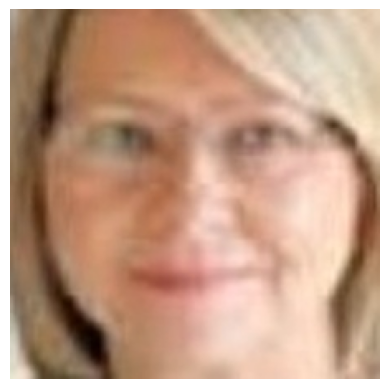

In [ ]:
# Remodeler et redimmensionner les donnés en une forme 3D 
pixels_list = df['pixels'].loc[0].split()  
pixels_array = np.array([int(pixel) for pixel in pixels_list], dtype=np.uint8)  
image_shape = (224, 224, 3)  
image_data_reshaped = pixels_array.reshape(image_shape)

# Afficher sous forme d'image
plt.imshow(image_data_reshaped)
plt.axis('off')  
plt.show()

### Pipeline Formation 

In [4]:
# Séparer les variables indépendantes (X) de la variable cible (y)
X = df[['gender','ethnicity','pixels']]
y = df["age"]

In [5]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.2,random_state=42)

In [9]:
# Définir les colonnes nécessitant une normalisation
binary_categorical_cols = ['gender'] 
categorical_cols = ['ethnicity']
pixels_cols=['pixels']

In [10]:
# Preprocesser les images
def preprocess_images(images):
    if isinstance(images, pd.Series):
        pixels_array = np.array(images.str.split().tolist(), dtype=np.float32) 
    else:
        pixels_array = np.array(images['pixels'].str.split().tolist(), dtype=np.float32) 
    if np.max(pixels_array) > 1:
        pixels_array = pixels_array / 255.0
    return pixels_array

image_preprocessor = FunctionTransformer(preprocess_images)

In [11]:
# Création du Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('pixels', image_preprocessor, pixels_cols),  # Normaliser la variable pixels
        ('bin_cat', 'passthrough', binary_categorical_cols),  # Ne rien faire pour les colonnes binaires
        ('other_cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Appliquer OneHotEncoder aux autres colonnes catégorielles
    ])

In [12]:
# Créer le pipeline avec le preprocessor et le modele Ridge
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())  
])

# Paramètres
params = {
    'regressor__alpha': [1.0, 10.0,20.0,50.0],
    'regressor__solver': ['auto', 'sparse_cg','svd'],
    'regressor__tol': [0.0001, 0.001, 0.01],
    'regressor__max_iter': [100, 500],
    'regressor__random_state': [42] 
}

# Utilisation d'un gridserach
grid_search = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

### Fit & Predict

In [13]:
# Entraîner le modèle
grid_search.fit(X_train, y_train)

/opt/mamba/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('pixels',
                                                                         FunctionTransformer(func=<function preprocess_images at 0x7f173abe1260>),
                                                                         ['pixels']),
                                                                        ('bin_cat',
                                                                         'passthrough',
                                                                         ['gender']),
                                                                        ('other_cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['ethnicity'])])),
                                       ('regressor', Ridge())]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [1.0, 10.0, 20.0, 50.0],
                         'regressor__max_iter': [100, 500],
                         'regressor__random_state': [42],
                         'regressor__solver': ['auto', 'sparse_cg', 'svd'],
                         'regressor__tol': [0.0001, 0.001, 0.01]},
             scoring='neg_mean_squared_error')

In [14]:
# Afficher les meilleurs paramètres et la meilleure performance
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure MSE:", -grid_search.best_score_)

Meilleurs paramètres: {'regressor__alpha': 50.0, 'regressor__max_iter': 100, 'regressor__random_state': 42, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}
Meilleure MSE: 195.67648047246908


In [15]:
# Prédire les valeurs sur les données d'entraînement et de test
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

# Calculer le MAE et le RMSE pour les données d'entraînement et de test
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# Afficher les résultats
print("MAE sur les données d'entraînement:", train_mae)
print("MAE sur les données de test:", test_mae)
print("RMSE sur les données d'entraînement:", train_rmse)
print("RMSE sur les données de test:", test_rmse)

MAE sur les données d'entraînement: 10.157323672339626
MAE sur les données de test: 10.520623689481381
RMSE sur les données d'entraînement: 13.150768145385427
RMSE sur les données de test: 13.707622904642417


/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Feature importance

In [17]:
# Accéder au modèle Ridge à partir du meilleur estimateur du GridSearchCV
ridge_model = grid_search.best_estimator_.named_steps['regressor']

# Récupréer les coefficients du modèle
coefficients = ridge_model.coef_

# Accéder aux noms des features après le prétraitement pour les pixels
pixel_feature_names = ['pixel_' + str(i) for i in range(len(coefficients) - 5)]  # Exclure les colonnes de genre et d'ethnicité

# Nom de la variable genre
genre_feature_name = 'genre'

# Noms des variables d'ethnicité
ethnicity_feature_names = ['ethnicity_' + str(i) for i in range(5)]

# Concaténer les noms de features des pixels, du genre et des ethnicités
feature_names = pixel_feature_names + [genre_feature_name] + ethnicity_feature_names


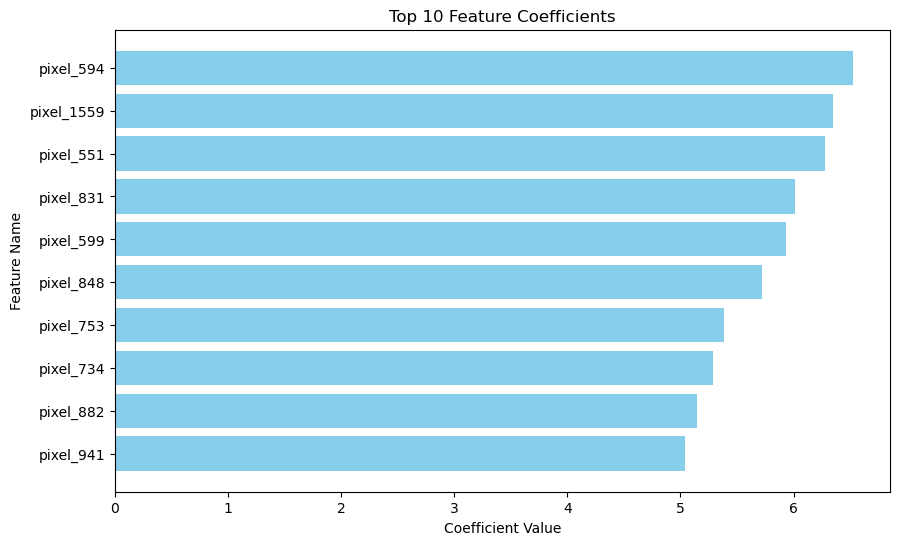

In [18]:
# Afficher les 10 variables les plus influentes
top_coefficients = sorted(zip(coefficients, feature_names), reverse=True)[:10]
top_feature_names = [name for coef, name in top_coefficients]
top_coefficients_values = [coef for coef, name in top_coefficients]

plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_coefficients_values, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Top 10 Feature Coefficients')
plt.gca().invert_yaxis()  
plt.show()


#### Explanation of results (train & test)

##### Train

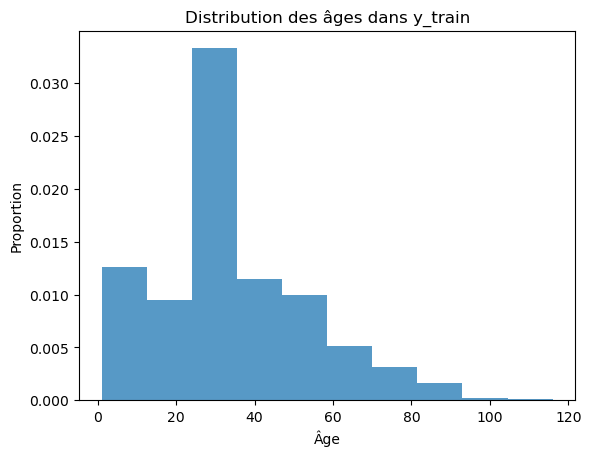

In [19]:
# Distribution des âges dans y_train
fig, ax = plt.subplots()
ax.hist(y_train, bins=10, density=True, alpha=0.75)
ax.set_title('Distribution des âges dans y_train')
ax.set_xlabel('Âge')
ax.set_ylabel('Proportion')
plt.show()

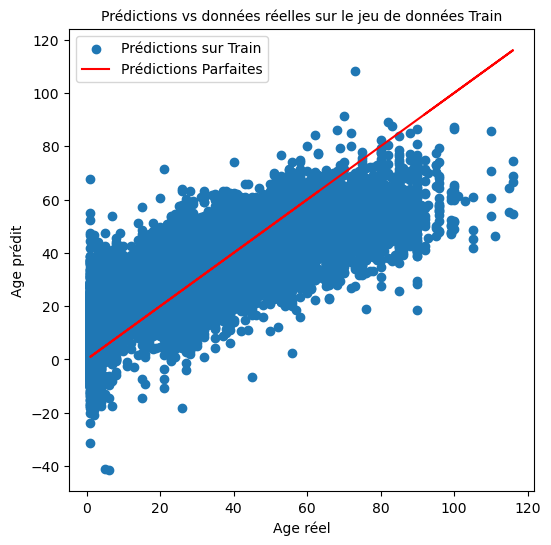

In [20]:
# Graphe des prédictions en fonction des valeurs réelles sur le jeu de données Train
plt.figure(figsize=(6, 6))
plt.scatter(y_train, grid_search.predict(X_train), label="Prédictions sur Train")
plt.plot(y_train, y_train, c="red", label="Prédictions Parfaites")
plt.legend()
plt.xlabel("Age réel")
plt.ylabel("Age prédit")
plt.title("Prédictions vs données réelles sur le jeu de données Train",fontsize=10)
plt.show()

In [21]:
# Définir les quantiles
quantiles = np.arange(0.1, 1.1, 0.1)

# Initialiser les listes pour stocker les résultats
quantile_values = []
mae_values = []
rmse_values = []

# Calculer les quantiles de y_train
y_train_quantiles = np.percentile(y_train, quantiles * 100)

# Boucle à travers chaque quantile
for i in range(len(quantiles)):
    # Sélectionner les données d'entraînement pour ce quantile
    y_train_quantile = y_train[(y_train > y_train_quantiles[i-1]) & (y_train <= y_train_quantiles[i])] if i != 0 else y_train[y_train <= y_train_quantiles[i]]
    y_train_pred_quantile = y_train_pred[(y_train > y_train_quantiles[i-1]) & (y_train <= y_train_quantiles[i])] if i != 0 else y_train_pred[y_train <= y_train_quantiles[i]]

    # Calculer MAE et RMSE
    mae = mean_absolute_error(y_train_quantile, y_train_pred_quantile)
    rmse = np.sqrt(mean_squared_error(y_train_quantile, y_train_pred_quantile))
    
    # Ajouter les valeurs aux listes
    quantile_values.append(y_train_quantiles[i])
    mae_values.append(mae)
    rmse_values.append(rmse)

# Créer un DataFrame pandas avec les résultats
results_df = pd.DataFrame({
    'Quantile': quantile_values,
    'MAE': mae_values,
    'RMSE': rmse_values
})

results_df

,Quantile,MAE,RMSE
0,5.0,11.806091,14.612972
1,20.0,12.461454,14.588038
2,25.0,7.717733,9.724216
3,26.0,7.572769,9.611329
4,29.0,7.457860,9.299891
5,34.0,6.862112,8.605960
6,40.0,6.781155,8.642534
7,50.0,7.949232,9.921035
8,61.0,11.265281,13.564922
9,116.0,22.307133,24.932759


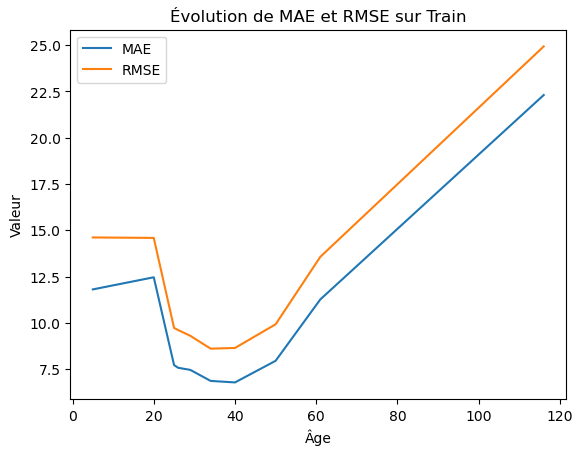

In [22]:
# Évolution de MAE et RMSE sur Train
fig, ax = plt.subplots()
ax.plot(results_df['Quantile'], results_df['MAE'], label='MAE')
ax.plot(results_df['Quantile'], results_df['RMSE'], label='RMSE')
ax.legend()
ax.set_title('Évolution de MAE et RMSE sur Train')
ax.set_xlabel('Âge')
ax.set_ylabel('Valeur')
plt.show()


##### Test

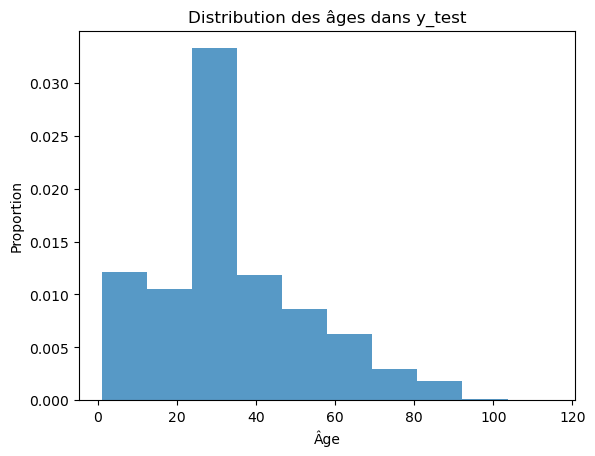

In [23]:
# Distribution des âges dans y_test
fig, ax = plt.subplots()
ax.hist(y_test, bins=10, density=True, alpha=0.75)
ax.set_title('Distribution des âges dans y_test')
ax.set_xlabel('Âge')
ax.set_ylabel('Proportion')
plt.show()

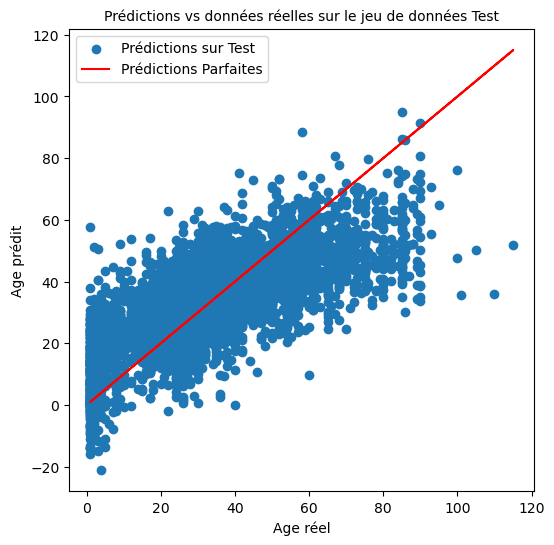

In [24]:
# Graphe des prédictions en fonction des valeurs réelles sur le jeu de données Test
plt.figure(figsize=(6, 6))
plt.scatter(y_test, grid_search.predict(X_test), label="Prédictions sur Test")
plt.plot(y_test, y_test, c="red", label="Prédictions Parfaites")
plt.legend()
plt.xlabel("Age réel")
plt.ylabel("Age prédit")
plt.title("Prédictions vs données réelles sur le jeu de données Test",fontsize=10)
plt.show()

In [25]:
# Définir les quantiles
quantiles = np.arange(0.1, 1.1, 0.1)

# Initialiser les listes pour stocker les résultats
quantile_values = []
mae_values = []
rmse_values = []

# Calculer les quantiles de y_test
y_test_quantiles = np.percentile(y_test, quantiles * 100)

# Boucle à travers chaque quantile
for i in range(len(quantiles)):
    # Sélectionner les données d'entraînement pour ce quantile
    y_test_quantile = y_test[(y_test > y_test_quantiles[i-1]) & (y_test <= y_test_quantiles[i])] if i != 0 else y_test[y_test <= y_test_quantiles[i]]
    y_test_pred_quantile = y_test_pred[(y_test > y_test_quantiles[i-1]) & (y_test <= y_test_quantiles[i])] if i != 0 else y_test_pred[y_test <= y_test_quantiles[i]]

    # Calculer MAE et RMSE
    mae = mean_absolute_error(y_test_quantile, y_test_pred_quantile)
    rmse = np.sqrt(mean_squared_error(y_test_quantile, y_test_pred_quantile))
    
    # Ajouter les valeurs aux listes
    quantile_values.append(y_test_quantiles[i])
    mae_values.append(mae)
    rmse_values.append(rmse)

# Créer un DataFrame pandas avec les résultats
results_df = pd.DataFrame({
    'Quantile': quantile_values,
    'MAE': mae_values,
    'RMSE': rmse_values
})

results_df

,Quantile,MAE,RMSE
0,7.0,12.225512,15.090816
1,20.0,12.573717,14.889051
2,25.0,7.761307,9.782376
3,26.0,7.607426,9.519667
4,29.0,7.793107,9.676204
5,35.0,7.054871,8.919097
6,40.0,7.638219,9.980863
7,50.0,8.603348,10.889611
8,61.0,11.848954,14.288808
9,115.0,23.326031,26.286875


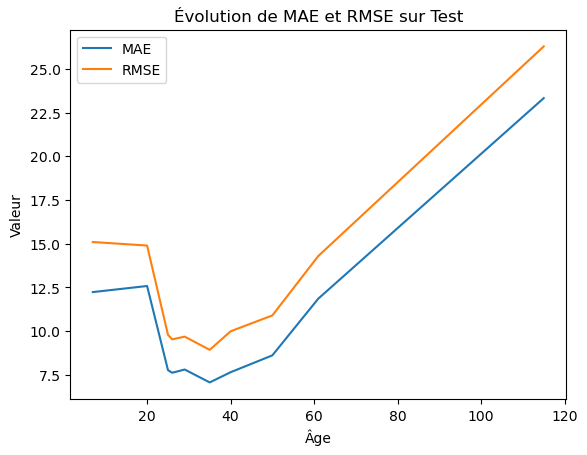

In [26]:
# Évolution de MAE et RMSE sur Test
fig, ax = plt.subplots()
ax.plot(results_df['Quantile'], results_df['MAE'], label='MAE')
ax.plot(results_df['Quantile'], results_df['RMSE'], label='RMSE')
ax.legend()
ax.set_title('Évolution de MAE et RMSE sur Test')
ax.set_xlabel('Âge')
ax.set_ylabel('Valeur')
plt.show()